# Solving SOMA MoCap Dataset
SOMA code uses [OmegaConf](https://omegaconf.readthedocs.io/en/2.1_branch/) to control different settings
while separating code from configuration files. You can find the configuration file for training SOMA at
```` soma/support_data/conf/soma_train_conf.yaml ````

You can change every value of the configuration inside the Jupyter, so you do not need to change the YAML file,
unless you want to change the default value for future cases.


## SOMA MoCap Dataset
SOMA dataset consists of two male subjects. You can obtain the unlabeled mocap point cloud (MPC) data from
[project's download webpage](https://download.is.tue.mpg.de/download.php?domain=soma&sfile=evaluation_mocaps/original/SOMA_dataset/SOMA_unlabeled_mpc.tar.bz2).
Place them under ```` support_files/evaluation_mocaps/original ````.

Also, get the
[markerlayout for SOMA dataset](https://download.is.tue.mpg.de/download.php?domain=soma&sfile=smplx/marker_layouts/SOMA.tar.bz2)
and place it under ```` support_files/marker_layouts ````.

## Prepare Body Dataset For Training
To create a synthetic mocap dataset, first, we need synthetic SMPL-X bodies in gender-neutral format.
SOMA is originally trained with body parameters corresponding to
ACCAD, CMU, HumanEVA, PosePrior, Total Capture, and Transitions datasets obtainable
from [AMASS downloads page](https://amass.is.tue.mpg.de/download.php).
Place the files under the directory identified by
```` dirs.amass_dir ````; e.g. ```` support_files/smplx/amass_neutral ````.

SOMA will turn these AMASS bodies into PyTorch pt files and h5 ones.

Alternatively, you can directly download the
[training body parameters without CAESAR subjects](https://download.is.tue.mpg.de/download.php?domain=soma&sfile=smplx/training_body_parameters/body_dataset.tar.bz2)
and place it under:
```` dirs.body_dataset_dir ````; e.g. ```` support_files/smplx/body_dataset ````.

## Prepare Body Model and Co.
Obtain a SMPL-X locked head body model for SOMA from [this link](https://smpl-x.is.tue.mpg.de/download.php).
Download the [extra smplx data](https://download.is.tue.mpg.de/download.php?domain=soma&sfile=smplx/extra_smplx_data.tar.bz2)
and place it in the smplx folder as you see in the above image.

Download the
[SSM head marker covariances](https://download.is.tue.mpg.de/soma/ssm_head_marker_corr.npz) and place it inside
```` dirs.support_base_dir ````; e.g. ```` support_files/ ````.

## Notes
- Due to licensing restrictions we cannot release the AMASS marker noise model and the CAESAR beta parameters.
In an ablative study in the paper, we have shown that these parameters improve the performance SOMA.
So without them it might be that the model you train would be underperforming, hence as an alternative, you can obtain the
[pretrained SOMA model for the SOMA dataset](https://download.is.tue.mpg.de/download.php?domain=soma&sfile=training_experiments/V48_02_SOMA.tar.bz2). 
We also release pretrained models for all the SOMA paper experiments.
- Addresses like ```` dirs.support_base_dir ```` point to a configuration key in the training YAML file; i.e.
```` soma/support_data/conf/soma_train_conf.yaml ````.
Check out the YAML file to learn more about the configurable settings.
All the key hierarchy is **dot accessible**, and we will show how to overload their values inside the code.
- The markerlayout could be only a c3d file in which case SOMA will run MoSh first to obtain the JSON file.
The markerlayout file you have already downloaded contains the JSON file.

Downloading stuff and placing it in the right location will hopefully pay pff; so just hang on :)

From here on, we will assume your uncompressed files and directories looks like this:

<img alt="alt text" height="256" src="https://download.is.tue.mpg.de/soma/tutorials/tutorial_training_folder_structure.png"
title="a mocap superset with 89 markers" width="256"/>

## Training SOMA
We have prepared a function that can train multiple SOMA models with various data settings; i.e.  ```` def train_multiple_soma ````
For the sake of this tutorial, we will train only one model using one GPU on the local machine.

To run a training experiment you need to decide on an experiment ID. The SOMA model lineup for ICCV'21 is V48_02 [*1].

Here we dive into the training code headfirst and later provide further explanation.

[*1]: Sure we trained more than 48 variants of SOMA.
Along the way, PyTorch lightning helped in reducing environmental impact by providing tools to detect issues early on in the training.


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

In [2]:
import os.path as osp
import numpy as np
from glob import glob

from soma.train.train_soma_multiple import train_multiple_soma

In [3]:
soma_expr_id = 'V48_02_SOMA'

soma_data_settings = [(5, 3, 0.0, 1.0), ] # upto 5 occlusions, upto 3 ghost points, 0.0% real data, 100. % synthetic data
soma_work_base_dir = '/home/naveen/Documents/Naveen/soma'
support_base_dir = osp.join(soma_work_base_dir, 'support_files')
soma_marker_layout_fname = osp.join(support_base_dir, 'marker_layouts/SOMA/soma_subject1/clap_001.c3d')

num_gpus = 1 # number of gpus for training
num_cpus = 1

In [ ]:
train_multiple_soma(
    soma_data_settings=soma_data_settings,
    soma_train_cfg={
        'soma.expr_id': soma_expr_id, # the experiment ID

        'dirs.support_base_dir': support_base_dir,
        'dirs.work_base_dir': soma_work_base_dir,
        'data_parms.mocap_dataset.amass_marker_noise_model.enable': False, # we cannot create amass marker noise model
        
        'moshpp_cfg_override.moshpp.verbosity': 1,
        'moshpp_cfg_override.dirs.support_base_dir':support_base_dir,

        'trainer.fast_dev_run': True, # if true then only one iteration of training and validation is done.

        'data_parms.mocap_dataset.marker_layout_fnames': [soma_marker_layout_fname],
        'train_parms.batch_size': 256,
        'trainer.num_gpus': num_gpus,
        'train_parms.num_workers': num_cpus,
    },
)

The above training code ran for an epoch and stoped because we had  ```` 'trainer.fast_dev_run': True ````.
Set this flag to False to run a full training.
Instead, let's simply download the already
[trained SOMA model](https://download.is.tue.mpg.de/download.php?domain=soma&sfile=training_experiments/V48_02_SOMA.tar.bz2).
Replace the weights from the snapshots directory in your local directory and that should be it.
Note that we assume you have not changed any of the model settings.
If you replace the whole folder you might need to download the corresponding
 [training data](https://download.is.tue.mpg.de/download.php?domain=soma&sfile=smplx/data/V48_01_SOMA.tar.bz2) and place it in the *data* folder.
The data folder keeps the settings required for trained model to work at runtime.

Note how we control the amount of noise during training; i.e. upto a number of ghost points or occlusions or ratio of real vs synthetic data.
For that we set *soma_data_settings* defined in the code above.
You can also change the distribution of ghost points by simply setting
```` 'data_parms.mocap_dataset.ghost_distribution' ```` a value from spherical_gaussian, uniform, skewed_gaussian.
Or you can disable random marker placement by setting ```` 'data_parms.marker_dataset.num_random_vid_ring': 0 ````.
Please have a look at the ```` soma_train_conf.yaml ```` to learn more about the possibilities.

You have control on the MoSh used to estimate the markerlayout by the keys under ```` moshpp_cfg_override ````.
The descendant keys actually override settings of MoSh configuration that has default values saved under
```` moshpp/support_data/conf/moshpp_conf.yaml ```` which is in the [moshpp repository](https://github.com/nghorbani/moshpp).

## Running SOMA On MoCap Point Cloud Data
The interface to run SOMA post training is the ```` run_soma_on_multiple_settings ````
that does exactly what its name suggests! i.e. run multiple SOMA models on various settings.
Running, includes all aspects of autolabeling, solving, rendering, and computing evaluation metrics.
For an overview of the capabilities of this interface refer to its docstring.
Let's first autolabel the
[SOMA dataset's MPC data](https://download.is.tue.mpg.de/download.php?domain=soma&sfile=evaluation_mocaps/original/SOMA_dataset/SOMA_unlabeled_mpc.tar.bz2). After downloadig the mocaps place it under:
```` support_files/evaluation_mocaps/original ````

In [4]:
import os.path as osp
from soma.train.soma_trainer import create_soma_data_id
from soma.run_soma.paper_plots.mosh_soma_dataset import gen_stagei_mocap_fnames
from soma.tools.run_soma_multiple import run_soma_on_multiple_settings
soma_data_ids = [create_soma_data_id(*soma_data_setting) for soma_data_setting in soma_data_settings]
print(soma_data_ids)
mocap_base_dir = osp.join(support_base_dir, 'evaluation_mocaps/original')
soma_mocap_target_ds_name = 'SOMA_unlabeled_mpc'

['OC_05_G_03_real_000_synt_100']


In [ ]:
run_soma_on_multiple_settings(
        soma_expr_ids=[soma_expr_id],
        soma_mocap_target_ds_names=[
            'SOMA_unlabeled_mpc',
        ],
        soma_data_ids=soma_data_ids,
        soma_cfg={
            'soma.batch_size': 512,
            'dirs.support_base_dir': support_base_dir,
            'mocap.unit': 'mm',
            'save_c3d': True,
            'keep_nan_points': True,  # required for labeling evaluation
            'remove_zero_trajectories': False  # required for labeling evaluation
        },
        mocap_base_dir=mocap_base_dir,
        run_tasks=['soma'],

        mocap_ext='.c3d',
        soma_work_base_dir = soma_work_base_dir,
        
        parallel_cfg = {
            # 'max_num_jobs': 1, # comment to run on all mocaps
            'randomly_run_jobs': True,
        },
    )

Note how we controlled SOMA configuration; i.e. batch_size, etc.
A new folder,

```` training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_labeled_mocap_tracklet ````

is created by the SOMA runtime code that holds the autolabeled mocaps.

Moving on, since we have the manually labeled ground-truth mocaps let's see how the labeling performance is.
For this download the
[manually labeled ground-truth SOMA dataset mocaps](https://download.is.tue.mpg.de/download.php?domain=soma&sfile=evaluation_mocaps/original/SOMA_dataset/SOMA_manual_labeled.tar.bz2)
and uncompress it inside ```` support_files/evaluation_mocaps/original ````.

In [8]:
# run_soma_on_multiple_settings(
#         soma_expr_ids=[soma_expr_id],
#         soma_mocap_target_ds_names=[soma_mocap_target_ds_name,],
#         soma_data_ids=soma_data_ids,
#         ds_name_gt='SOMA_manual_labeled',
#         mocap_base_dir=mocap_base_dir,
#         eval_label_cfg={'dirs.support_base_dir':support_base_dir},
#         run_tasks=['eval_label'],
# #         fast_dev_run=True,
#         mocap_ext='.c3d',
#         soma_work_base_dir = soma_work_base_dir,
#         parallel_cfg = {
# #             'max_num_jobs': 1, # comment to run on all mocaps
#             'randomly_run_jobs': True,
#         },
#     )

In the log output above, the green lines show the final result per sequence; i.e. perseq.
Meanwhile, SOMA runtime code has created another folder holding the labeling evaluation results; i.e.

```` training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/soma_eval_tracklet ````

Let's aggregate these results into one number per dataset.

In [9]:
# run_soma_on_multiple_settings(
#         soma_expr_ids=[soma_expr_id],
#         soma_mocap_target_ds_names=[soma_mocap_target_ds_name,],
#         soma_data_ids=soma_data_ids,
#         ds_name_gt='SOMA_manual_labeled',
#         mocap_base_dir=mocap_base_dir,
#         eval_label_cfg={'dirs.support_base_dir':support_base_dir},
#         run_tasks=['eval_label_aggregate'],
# #         fast_dev_run=True,
#         mocap_ext='.c3d',
#         soma_work_base_dir = soma_work_base_dir,
#         parallel_cfg = {
# #             'max_num_jobs': 1, # comment to run on all mocaps
#             'randomly_run_jobs': True,
#         },
#     )

And these are the results for the whole SOMA dataset using the pretrained model which should be the same as the one presented in the paper.
Another directory is  created at the root directory
holding the Excel file including the aggregated as well as the detailed summary of the labeling evaluation:

```` evaluations/SOMA_unlabeled_mpc_V49_01_SOMA_OC_05_G_03_real_000_synt_100_tracklet_labeling.xlsx ````


The evaluation excel filenames have the following format:
````
(A:dataset name)___(B:marker layout)__(C:moocap corrupting noise settings)_(D:experiment id)_(E:training noise model settings)_(F:(tracklet) labeling/v2v).xlsx
````
As an example

````
SOMA_unlabeled_mpc_V49_01_SOMA_OC_05_G_03_real_000_synt_100_tracklet_labeling.xlsx
````

could be segmented into:
````
(A:SOMA_unlabeled_mpc)_(B: not used in real data)_(C:not used in read data)_(D:V49_01_SOMA)_(E:OC_05_G_30_real_000_synt_100)_(F:tracklet labeling).xlsx_
````


Next we will run MoSh++ on the autolabeled mocaps and get the solved bodies.

## Solving Bodies with MoSh++

During the first stage, MoSh++ uses 12 frames randomly selected from subject specific mocaps to estimate the shape of the subject and
 placement of the markers.
These 12 frames should have the same frame number so that the results for the second stage of MoSh++ would be comparable.
To achieve this we use *gen_stagei_mocap_fnames* for the SOMA dataset mocaps.
Here we see flexibility of the SOMA runtime code in new scenarios.

Current MoSh code runs on single **CPU** hence it is very slow. Specially the first stage of MoSh would be the slowest.
Therefore, we run the code over the first 10 frames for demonstration purposes.

In [ ]:
for subject_name in [
    'soma_subject1',
    # 'soma_subject2' # uncomment to process this subject as well
]:
    mocap_dir = osp.join(soma_work_base_dir,
                         'training_experiments',
                         soma_expr_id, soma_data_ids[0],
                         'evaluations',
                         'soma_labeled_mocap_tracklet',
                         soma_mocap_target_ds_name)
    # stagei_mocap_fnames = gen_stagei_mocap_fnames(mocap_dir, subject_name, ext='.pkl')

    run_soma_on_multiple_settings(
        soma_expr_ids=[
            soma_expr_id,
        ],
        soma_mocap_target_ds_names=[
            'SOMA_unlabeled_mpc',
        ],
        soma_data_ids=
        soma_data_ids,
        mosh_cfg={
            'moshpp.verbosity': 1,  # set to two to visualize the process in psbody.mesh.mesh_viewer
            # 'moshpp.stagei_frame_picker.stagei_mocap_fnames': stagei_mocap_fnames,
            # 'moshpp.stagei_frame_picker.type': 'manual',
            'moshpp.stagei_frame_picker.type': 'random',

            'dirs.support_base_dir': support_base_dir,

            # 'mocap.end_fidx': 10  # comment in real runs
        },
        mocap_base_dir=mocap_base_dir,
        run_tasks=['mosh'],
        fname_filter=[subject_name],
        #         fast_dev_run=True,
        mocap_ext='.c3d',
        soma_work_base_dir=soma_work_base_dir,
        parallel_cfg={
            # 'max_num_jobs': 1,  # comment to run on all mocaps
            'randomly_run_jobs': True,
        },

    )


You can download the already
[computed MoSh++ results for the whole SOMA dataset using the SOMA autolabeled mocaps](https://download.is.tue.mpg.de/download.php?domain=soma&sfile=evaluation_mocaps/original/SOMA_dataset/mosh_results/SOMA_soma_autolabeled.tar.bz2)
and place them inside the experiment folder, substituting the contents already created at
```` training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/mosh_results_tracklet ````.

Now download the 
[MoSh++ results for manually labeled mocaps](https://download.is.tue.mpg.de/download.php?domain=soma&sfile=evaluation_mocaps/original/SOMA_dataset/mosh_results/SOMA_manual_labeled.tar.bz2)
and place them at the root directory; i.e.
```` support_files/mosh_results/SOMA_manual_labeled  ````.
Note that here we created a *moh_results* directory for better organization of the files.

Now we can actually compute vertex-to-vertex error in reconstructing the body surface.

In [11]:
# gt_mosh_base_dir= osp.join(support_base_dir, 'mosh_results')

# run_soma_on_multiple_settings(
#         soma_expr_ids=[soma_expr_id],
#         soma_mocap_target_ds_names=[soma_mocap_target_ds_name,],
#         soma_data_ids=soma_data_ids,
#         ds_name_gt='SOMA_manual_labeled',
#         mocap_base_dir=mocap_base_dir,
#         eval_v2v_cfg={'dirs.support_base_dir':support_base_dir},

#         run_tasks=['eval_v2v'],

#         mocap_ext='.c3d',
#         gt_mosh_base_dir=gt_mosh_base_dir,
#         soma_work_base_dir = soma_work_base_dir,
#         parallel_cfg = {
#             # 'max_num_jobs': 3, # comment to run on all mocaps
#             'randomly_run_jobs': True,
#         },
#     )

Similar to the labeling evaluations we have to run the SOMA interface once more with
*eval_v2v_aggregate* to aggregate the perseq results into one number.

In [12]:
# run_soma_on_multiple_settings(
#         soma_expr_ids=[soma_expr_id],
#         soma_mocap_target_ds_names=[soma_mocap_target_ds_name,],
#         soma_data_ids=soma_data_ids,
#         ds_name_gt='SOMA_manual_labeled',
#         mocap_base_dir=mocap_base_dir,
#         run_tasks=['eval_v2v_aggregate'],

#         # fast_dev_run=True,

#         mocap_ext='.c3d',
#         gt_mosh_base_dir=gt_mosh_base_dir,

#         soma_work_base_dir = soma_work_base_dir,
#         parallel_cfg = {
# #             'max_num_jobs': 1, # comment to run on all mocaps
#             'randomly_run_jobs': True,
#         },
#     )

These numbers follow the ones presented in the paper.

So far we have autolabeled, and solved the given mocaps.
Furthermore, we have evaluated our SOMA results with regard to labeling performance and surface reconstruction accuracy.
New let's see how we can render the solved bodies.

## Rendering Solved Bodies

If you have installed Blender 2.83-LTS following the installation instructions you can also render solved bodies using Blender.  Download the 
[Blender blend files](https://download.is.tue.mpg.de/download.php?domain=soma&sfile=blender/blend_files.tar.bz2)
and place them under
```` support_files/blender/blend_files ````.


In [5]:
blender_temp_dir = osp.join(soma_work_base_dir, 'blender_temp')

In [6]:
run_soma_on_multiple_settings(
        soma_expr_ids=[soma_expr_id],
        soma_mocap_target_ds_names=[
            'SOMA_unlabeled_mpc',
        ],
        soma_data_ids=soma_data_ids,
        render_cfg={
            'moshpp.verbosity': 1,
            # 'render.render_only_one_image': True, # uncomment for initial testing of the pipeline
            'render.show_markers': True,
            'render.video_fps': 15,  # 25,
            'mesh.ds_rate': 5,
            'render.save_final_blend_file': False,
            'render.resolution.change_from_blend': True,
            'render.resolution.default': [1600, 1600],  # [x,y]
            'render.render_engine': 'eevee',  # eevee / cycles,
            'dirs.temp_base_dir': blender_temp_dir,
            'dirs.support_base_dir': support_base_dir,

        },
        mocap_base_dir=mocap_base_dir,
        run_tasks=['render'],

        parallel_cfg = {
            # 'max_num_jobs': 1, # comment to run on all mocaps
            'randomly_run_jobs': True,
        },

        mocap_ext='.c3d',
        soma_work_base_dir = soma_work_base_dir
    )

2024-09-25 12:43:12.367 | INFO     | soma.tools.run_soma_multiple:run_soma_on_multiple_settings:260 - Submitting render jobs.
2024-09-25 12:43:12.371 | INFO     | soma.tools.parallel_tools:run_parallel_jobs:97 - #Job(s) submitted: 6
2024-09-25 12:43:12.372 | INFO     | soma.tools.parallel_tools:run_parallel_jobs:110 - Will run the jobs in random order.
2024-09-25 12:43:12.383 | INFO     | soma.render.parameters_to_mesh:convert_to_mesh_once:61 - Preparing mesh files for: ['/home/naveen/Documents/Naveen/soma/training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/mosh_results_tracklet/SOMA_unlabeled_mpc/soma_subject1/dance_001_stageii.pkl']
2024-09-25 12:43:12.385 | INFO     | soma.render.parameters_to_mesh:convert_to_mesh_once:62 - dirs.mesh_out_dir: /home/naveen/Documents/Naveen/soma/blender_temp/SOMA_unlabeled_mpc/mesh_files/soma_subject1_dance_001
2024-09-25 12:43:27.268 | INFO     | soma.render.parameters_to_mesh:convert_to_mesh_once:203 - Created /home/naveen/Docu

Read blend: /home/naveen/Documents/Naveen/soma/support_files/blender/blend_files/soma_standard.blend
/home/naveen/Documents/Naveen/soma/blender_temp/SOMA_unlabeled_mpc/mesh_files/soma_subject1_dance_001/body_mesh/*.obj
Info: Deleted 4 object(s)
(  0.0000 sec |   0.0000 sec) Importing OBJ '/home/naveen/Documents/Naveen/soma/blender_temp/SOMA_unlabeled_mpc/mesh_files/soma_subject1_dance_001/body_mesh/00000.obj'...
  (  0.0000 sec |   0.0000 sec) Parsing OBJ file...
    (  0.1363 sec |   0.1363 sec) Done, loading materials and images...
    (  0.1370 sec |   0.1370 sec) Done, building geometries (verts:10475 faces:20908 materials: 1 smoothgroups:0) ...
    (  0.1683 sec |   0.1683 sec) Done.
  (  0.1684 sec |   0.1683 sec) Finished importing: '/home/naveen/Documents/Naveen/soma/blender_temp/SOMA_unlabeled_mpc/mesh_files/soma_subject1_dance_001/body_mesh/00000.obj'
Progress: 100.00%


Successfully imported '/home/naveen/Documents/Naveen/soma/blender_temp/SOMA_unlabeled_mpc/mesh_files/soma_

2024-09-25 12:43:28.345 | SUCCESS  | soma.render.mesh_to_video_standard:run_blender_once:135 - created /home/naveen/Documents/Naveen/soma/blender_temp/SOMA_unlabeled_mpc/png_files/soma_standard/soma_subject1_dance_001/00000.png


Info: Deleted 4 object(s)


: 

Found 488 rendered images. showing one!


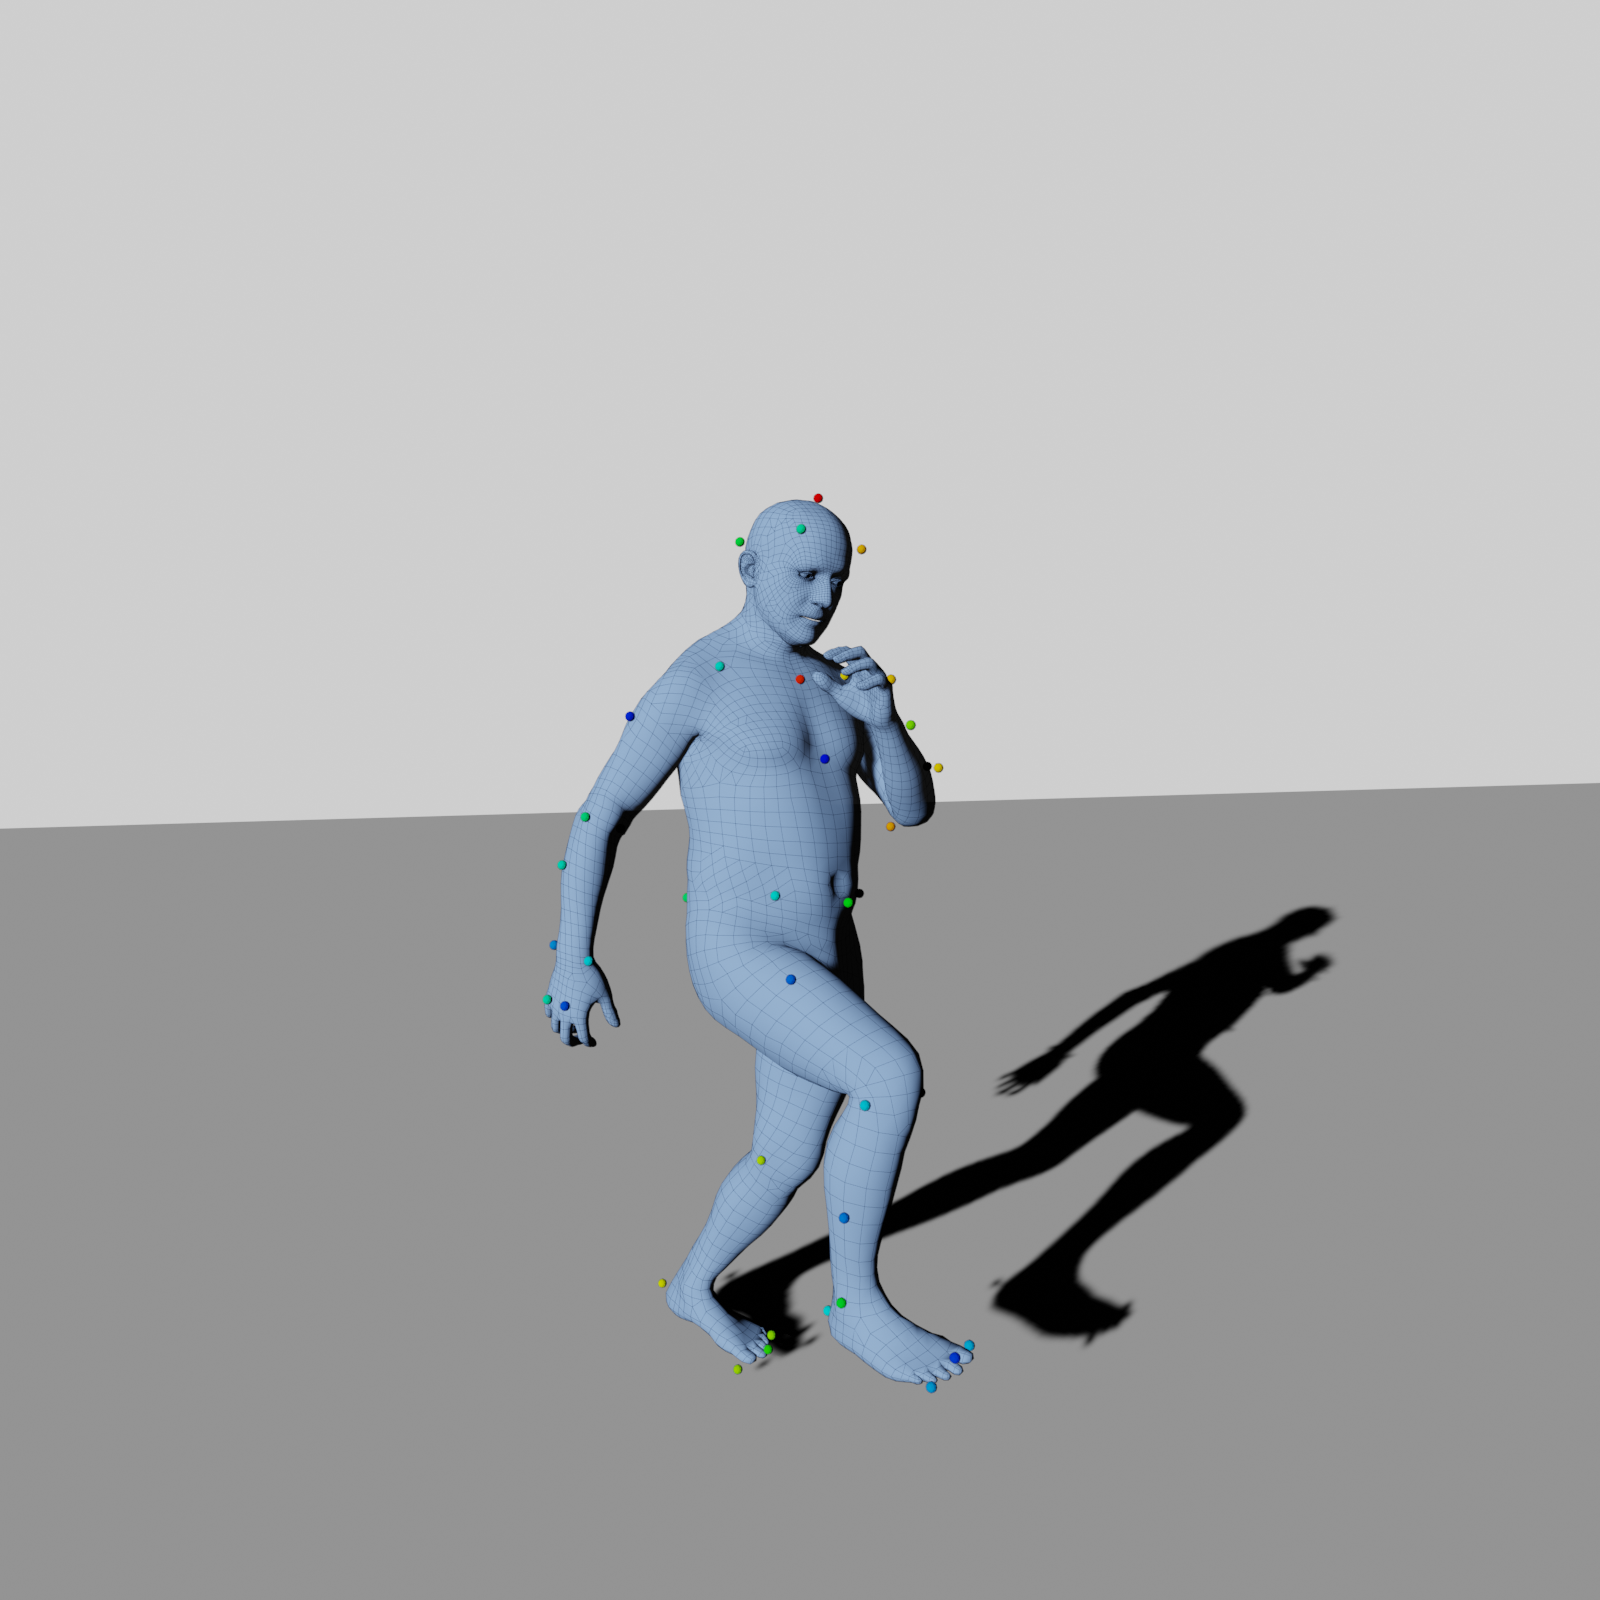

In [6]:
from glob import glob
import random
from IPython.display import Image

render_image_fnames = glob(osp.join(blender_temp_dir, 'SOMA_unlabeled_mpc', 'png_files', 'soma_standard', '*/*.png'))
print(f'Found {len(render_image_fnames)} rendered images. showing one!')

random.shuffle(render_image_fnames)
Image(filename=render_image_fnames[0]) 

You can use the
[AMASS tutorials](https://github.com/nghorbani/amass/blob/master/notebooks/01-AMASS_Visualization.ipynb)
and the [body visualizer](https://github.com/nghorbani/body_visualizer)
 to turn mosh pkl files into AMASS npz format on the fly and render in Jupyter. Let's have a look.

In [ ]:
from moshpp.mosh_head import MoSh
import numpy as np

mosh_stageii_pkl_fname = osp.join(soma_work_base_dir, 'training_experiments/V48_02_SOMA/OC_05_G_03_real_000_synt_100/evaluations/mosh_results_tracklet/SOMA_unlabeled_mpc/soma_subject1/clap_001_stageii.pkl')
mosh_result = MoSh.load_as_amass_npz(mosh_stageii_pkl_fname, include_markers=True)
print({k:v if isinstance(v, str) or isinstance(v,float) or isinstance(v,int) else v.shape for k,v in mosh_result.items() if not isinstance(v, list) and not isinstance(v,dict)})

time_length = len(mosh_result['trans'])
mosh_result['betas'] = np.repeat(mosh_result['betas'][None], repeats=time_length, axis=0)

subject_gender = mosh_result['gender']
surface_model_type = mosh_result['surface_model_type']
print(f'subject_gender: {subject_gender}, surface_model_type: {surface_model_type}, time_length: {time_length}')

In [7]:
import trimesh
from body_visualizer.tools.vis_tools import colors
from body_visualizer.mesh.mesh_viewer import MeshViewer
from body_visualizer.mesh.sphere import points_to_spheres
from body_visualizer.tools.vis_tools import show_image

imw, imh=1600, 1600
mv = MeshViewer(width=imw, height=imh, use_offscreen=True)

ModuleNotFoundError: No module named 'pyrender'

In [17]:
from human_body_prior.body_model.body_model import BodyModel
import torch
from human_body_prior.tools.omni_tools import copy2cpu as c2c 

comp_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


bm_fname = osp.join(soma_work_base_dir, f'support_files/{surface_model_type}/{subject_gender}/model.npz')

num_betas = mosh_result['num_betas'] # number of body parameters

bm = BodyModel(bm_fname=bm_fname, num_betas=num_betas).to(comp_device)
faces = c2c(bm.f)

In [ ]:
body_parms = {k:torch.Tensor(v).to(comp_device) for k,v in mosh_result.items() if k in ['pose_body', 'betas', 'pose_hand']}
print({k:v.shape for k,v in body_parms.items()})

In [ ]:
body_pose_hand = bm(**body_parms)

def vis_body_pose_hand(fId = 0):
    body_mesh = trimesh.Trimesh(vertices=c2c(body_pose_hand.v[fId]), faces=faces, vertex_colors=np.tile(colors['grey'], (6890, 1)))
    mv.set_static_meshes([body_mesh])
    body_image = mv.render(render_wireframe=False)
    show_image(body_image)

vis_body_pose_hand(fId=8)

You can change the *fId* to render another frame. 